Done: %10.0
Done: %20.0
Done: %30.0
Done: %40.0
Done: %50.0
Done: %60.0
Done: %70.0
Done: %80.0
Done: %90.0
Done: %100.0
Training finished.



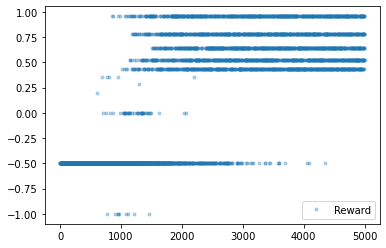

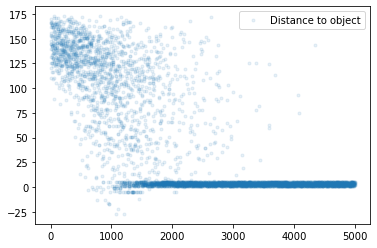

In [55]:
# Core Library
import math
import random
from typing import Any, Dict, List, Tuple

# Third party
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces


# Hyperparameters
alpha = 0.1
gamma = 0
epsilon = 1

# For plotting metrics
all_epochs = []
all_penalties = []


q_table = np.zeros([210, 2])


class AEBEnv(gym.Env):
    """
    Define a simple Track environment.

    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """

    def __init__(self, start, object_position, maximum_brake_acc, initial_speed):
        self.starting_distance = start
        self.object_position = object_position
        self.is_car_stopped = False

        # self.car_weight = weight  # measured in kg
        self.maximum_brake_acc = maximum_brake_acc  # measured in m/s2
        self.initial_speed = initial_speed  # measured in m/s

        self.current_speed = initial_speed
        self.current_position = 0

        # Define what the agent can do
        ### Brake at 0.0 or 1.0 intensity
        self.action_space = spaces.Discrete(2)

        # Observation is the remaining distance
        low = np.array([0.0])
        high = np.array([self.current_position - object_position])
        self.observation_space = spaces.Box(low, high, dtype=float)

        # Store what the agent tried
        self.current_episode = -1
        self.action_episode_memory: List[any] = []

    def step(self, action: int) -> Tuple[int, float, bool, int]:
        """
        The agent takes a step in the environment.

        Parameters
        ----------
        action : float

        Returns
        -------
        ob, reward, episode_over, info : tuple
            ob : List[int]
                an environment-specific object representing your observation of
                the environment.
            reward : float
                amount of reward achieved by the previous action. The scale
                varies between environments, but the goal is always to increase
                your total reward.
            episode_over : bool
                whether it's time to reset the environment again. Most (but not
                all) tasks are divided up into well-defined episodes, and done
                being True indicates the episode has terminated. (For example,
                perhaps the pole tipped too far, or you lost your last life.)
            info : Dict
                 diagnostic information useful for debugging. It can sometimes
                 be useful for learning (for example, it might contain the raw
                 probabilities behind the environment's last state change).
                 However, official evaluations of your agent are not allowed to
                 use this for learning.
        """
        self.curr_step += 1
        
        #brake_intensity = float(action / 10)

        self._take_action(action)
        reward = self._get_reward()
        ob = self._get_state()
        info = self.object_position - self.current_position
        return ob, reward, self.is_car_stopped, info

    def _take_action(self, action: int) -> None:
        self.action_episode_memory[self.current_episode].append(action)

        #self.decrease_speed(action)
        if action == 0:
            return
        else:
            self.calculate_stopping_point(action)

            ##is_car_stopped = self.current_speed == 0
            self.is_car_stopped = True

    def _get_reward(self) -> float:
        """Reward is given according to the distance to the object."""
        distance = self.object_position - self.current_position
        desired_distance = 10
        if self.is_car_stopped == True:
            if distance > desired_distance:
                return -.5
            elif distance < 0:
                #print('-10')
                return -1
            else:
                #reward_tmp = math.exp(-(desired_distance - distance) / desired_distance)
                reward_tmp = math.exp(-(desired_distance - distance)/5)
                return reward_tmp
        else:
            return 0

    def reset(self, initial_distance) -> List[int]:
        """
        Reset the state of the environment and returns an initial observation.

        Returns
        -------
        observation: List[int]
            The initial observation of the space.
        """
        self.curr_step = -1
        self.current_episode += 1
        self.action_episode_memory.append([])
        self.is_car_stopped = False
        self.current_speed = self.initial_speed
        self.current_position = 0
        self.object_position = initial_distance
        return 0

    def _render(self, mode: str = 'human', close: bool = False) -> None:
        return None

    def _get_state(self) -> List[int]:
        """Get the observation."""
        self.current_position = self.current_position + 5
        ob = self.object_position - self.current_position
        ob = int(ob)
        return ob


    def decrease_speed(self, multiplier):
        self.current_speed = self.current_speed - (multiplier * self.maximum_brake_acc)
        if self.current_speed <= 0:
            self.is_car_stopped = True

    # calculates the distance the car travels before stopping
    def calculate_stopping_point(self, action):
        # time_travelled = speed / brake
        #brake_acc_applied = float(self.maximum_brake_acc * action / 10)
        distance_travelled = (self.current_speed ** 2) / (2 * self.maximum_brake_acc)
        self.current_position = self.current_position + distance_travelled


starting_distance = random.randint(150, 200)
env = AEBEnv(0, starting_distance, 9, 20)

total_epochs = []
total_penalties = []
total_rewards = []
total_distances = []

episodes_tr = 5001
for i in range(1, episodes_tr):
    epsilon = math.exp(-i/512)
    
    starting_distance = random.randint(150, 200)
    state = env.reset(starting_distance)

    epochs, penalties, reward, = 0, 0, 0
    done = False
    info = starting_distance
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space which is (only braking) braking intensity
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action)
        
        if next_state < 0 or next_state > starting_distance:
            done = True
            break
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward < 0:
            penalties += 1

        state = next_state
        epochs += 1
        
    total_distances.append(info)
    total_epochs.append(epochs)
    total_penalties.append(penalties)
    total_rewards.append(reward)
    
    if i % 500 == 0:
        #print(f"Episode: {i}")
        print(f"Done: %{i/50}")


print("Training finished.\n")

plt.plot(total_rewards, linestyle = 'None', marker='.', alpha = .3, label = 'Reward')
plt.legend(loc = 'lower right')
plt.show()

plt.plot(total_distances, marker='.', linestyle='None', alpha = .1, label = 'Distance to object')
plt.legend()
plt.show()

